# Calculate average color-channels
This notebook calculates average values in color-channels in color spaces.

Input files: "masked/df.csv"<br>
Output files: "working/df_colors.csv"

In [1]:
from derm_ita import get_ita
from derm_ita import get_structured_patches_ita
from PIL import Image
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans

In [2]:
%run Colors/Skin_color_functions.ipynb

In [3]:
root = "d:/ham/"
df_path = root + "masked/df.csv"
df = pd.read_csv(df_path)
df["labels"] = df['labels'].apply(lambda x: str(x))
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10015 entries, 0 to 10014
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   lesion_id     10015 non-null  object 
 1   image_id      10015 non-null  object 
 2   dx            10015 non-null  object 
 3   dx_type       10015 non-null  object 
 4   age           9958 non-null   float64
 5   sex           10015 non-null  object 
 6   localization  10015 non-null  object 
 7   filepaths     10015 non-null  object 
 8   cell_type     10015 non-null  object 
 9   labels        10015 non-null  object 
 10  ita           10015 non-null  float64
 11  ita labels    10015 non-null  int64  
dtypes: float64(2), int64(1), object(9)
memory usage: 939.0+ KB


In [4]:
df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,filepaths,cell_type,labels,ita,ita labels
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,d:/ham/ham/HAM10000_images_part_1/ISIC_0027419...,Benign keratosis-like lesions,2,101.800684,1
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,d:/ham/ham/HAM10000_images_part_1/ISIC_0025030...,Benign keratosis-like lesions,2,103.164404,1
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,d:/ham/ham/HAM10000_images_part_1/ISIC_0026769...,Benign keratosis-like lesions,2,92.573301,1
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,d:/ham/ham/HAM10000_images_part_1/ISIC_0025661...,Benign keratosis-like lesions,2,89.417921,1
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,d:/ham/ham/HAM10000_images_part_2/ISIC_0031633...,Benign keratosis-like lesions,2,96.993318,1


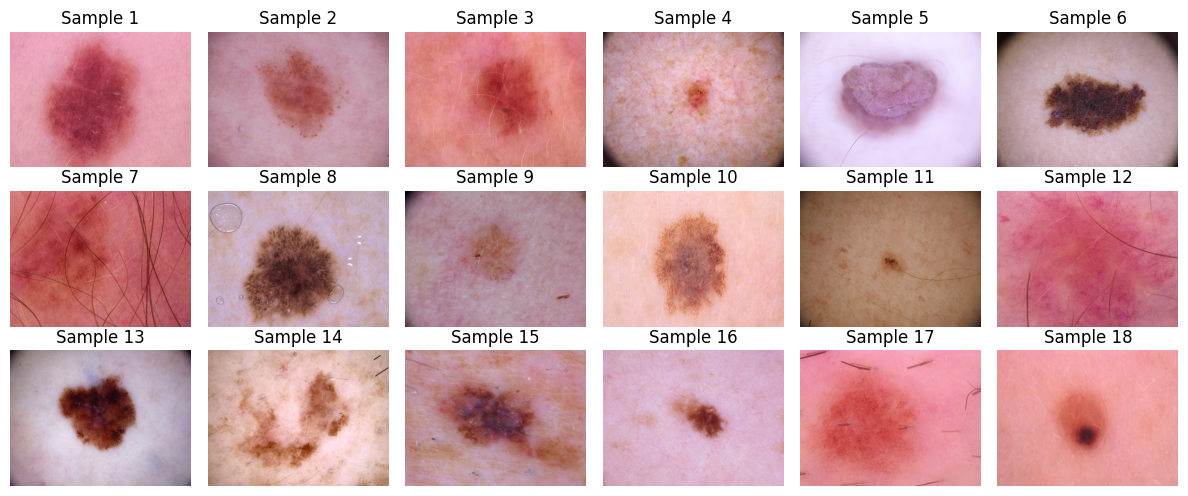

In [5]:
samples = df["filepaths"].sample(n=18, random_state=20)

fig, axes = plt.subplots(3, 6, figsize=(12, 5))
                         
for i, ax in enumerate(axes.flat):
    if i < len(samples):
        img = cv2.imread(samples.values[i])
        ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        ax.set_title(f"Sample {i + 1}")
        ax.axis("off")
            
plt.tight_layout()
plt.show()

<font color="green"><h1>Extract channel information</h1></font>

In [6]:
color_space_mappings = {
    "RGB": cv2.COLOR_BGR2RGB, "HSV": cv2.COLOR_BGR2HSV, "LAB": cv2.COLOR_BGR2LAB, "YCrCb": cv2.COLOR_BGR2YCrCb}

In [7]:
def skin_color_mean_values(path, color_space):
    img = cv2.imread(path)
    img = cv2.cvtColor(img, color_space_mappings[color_space])
    #red_channel = img[:, :, 0]
    color_df = pd.DataFrame(img.reshape(-1, 3), columns=list(color_space))
    
    kmeans = KMeans(n_clusters=2, n_init="auto", random_state=42)
    kmeans.fit(color_df)
    color_df["Cluster"] = kmeans.labels_
    centroids = kmeans.cluster_centers_
    
    # Create a mask for the darker cluster, 0 is darker
    darker_cluster = 0 if is_darker(color_space, centroids[0], centroids[1]) else 1
    color_df["Cluster"] == darker_cluster
    
    channel_1 = color_df[color_df["Cluster"] == 1][list(color_space)[0]].mean()
    channel_2 = color_df[color_df["Cluster"] == 1][list(color_space)[1]].mean()
    channel_3 = color_df[color_df["Cluster"] == 1][list(color_space)[2]].mean()
    return channel_1, channel_2, channel_3

In [8]:
def average_colors(color_space):
    c_channels = list(color_space)
    
    channels_1 = []
    channels_2 = []
    channels_3 = []
    
    for d in df["filepaths"]:
        channel_1, channel_2, channel_3 = skin_color_mean_values(d, color_space)
        channels_1.append(channel_1)
        channels_2.append(channel_2)
        channels_3.append(channel_3)
        
    df["{} {}".format(color_space, c_channels[0])] = channels_1
    df["{} {}".format(color_space, c_channels[1])] = channels_2
    df["{} {}".format(color_space, c_channels[2])] = channels_3

In [9]:
average_colors("RGB")
average_colors("HSV")
average_colors("LAB")

In [10]:
df.to_csv(root + "working/df_colors.csv", index=False)